### Analyse et predictions des prix de l'immobilier (Ames Housing)
Objectifs :
- Analyser les données et tirée le maximum d'informations
- construire un modèle capable de predire ,avec le moins d'erreur possible,le prix des maisons  




I-) Importation des bibliotheques 

In [49]:
## Importation des librairies 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb 
import lightgbm as lgb 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


II-) Importation et traitement des données 
- II-1-)importation des donnees 

In [16]:
## Importation des jeus de données 
data_train=pd.read_csv("train.csv")
data_test=pd.read_csv("test.csv")

- II-2-)exploration des données 

In [17]:
## exploration des données 
print("Aperçu des données d'entraînement :")
print("="*150)
print(data_train.head())
print("="*150)
print("Voici les informations sur le jeu de données d'entraînement :")
print(data_train.info())
print("="*150)
print("Statistiques descriptives du jeu de données d'entraînement :")
print(data_train.describe())

Aperçu des données d'entraînement :
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleConditio

- II-3-) analyse de correlation entre variables 

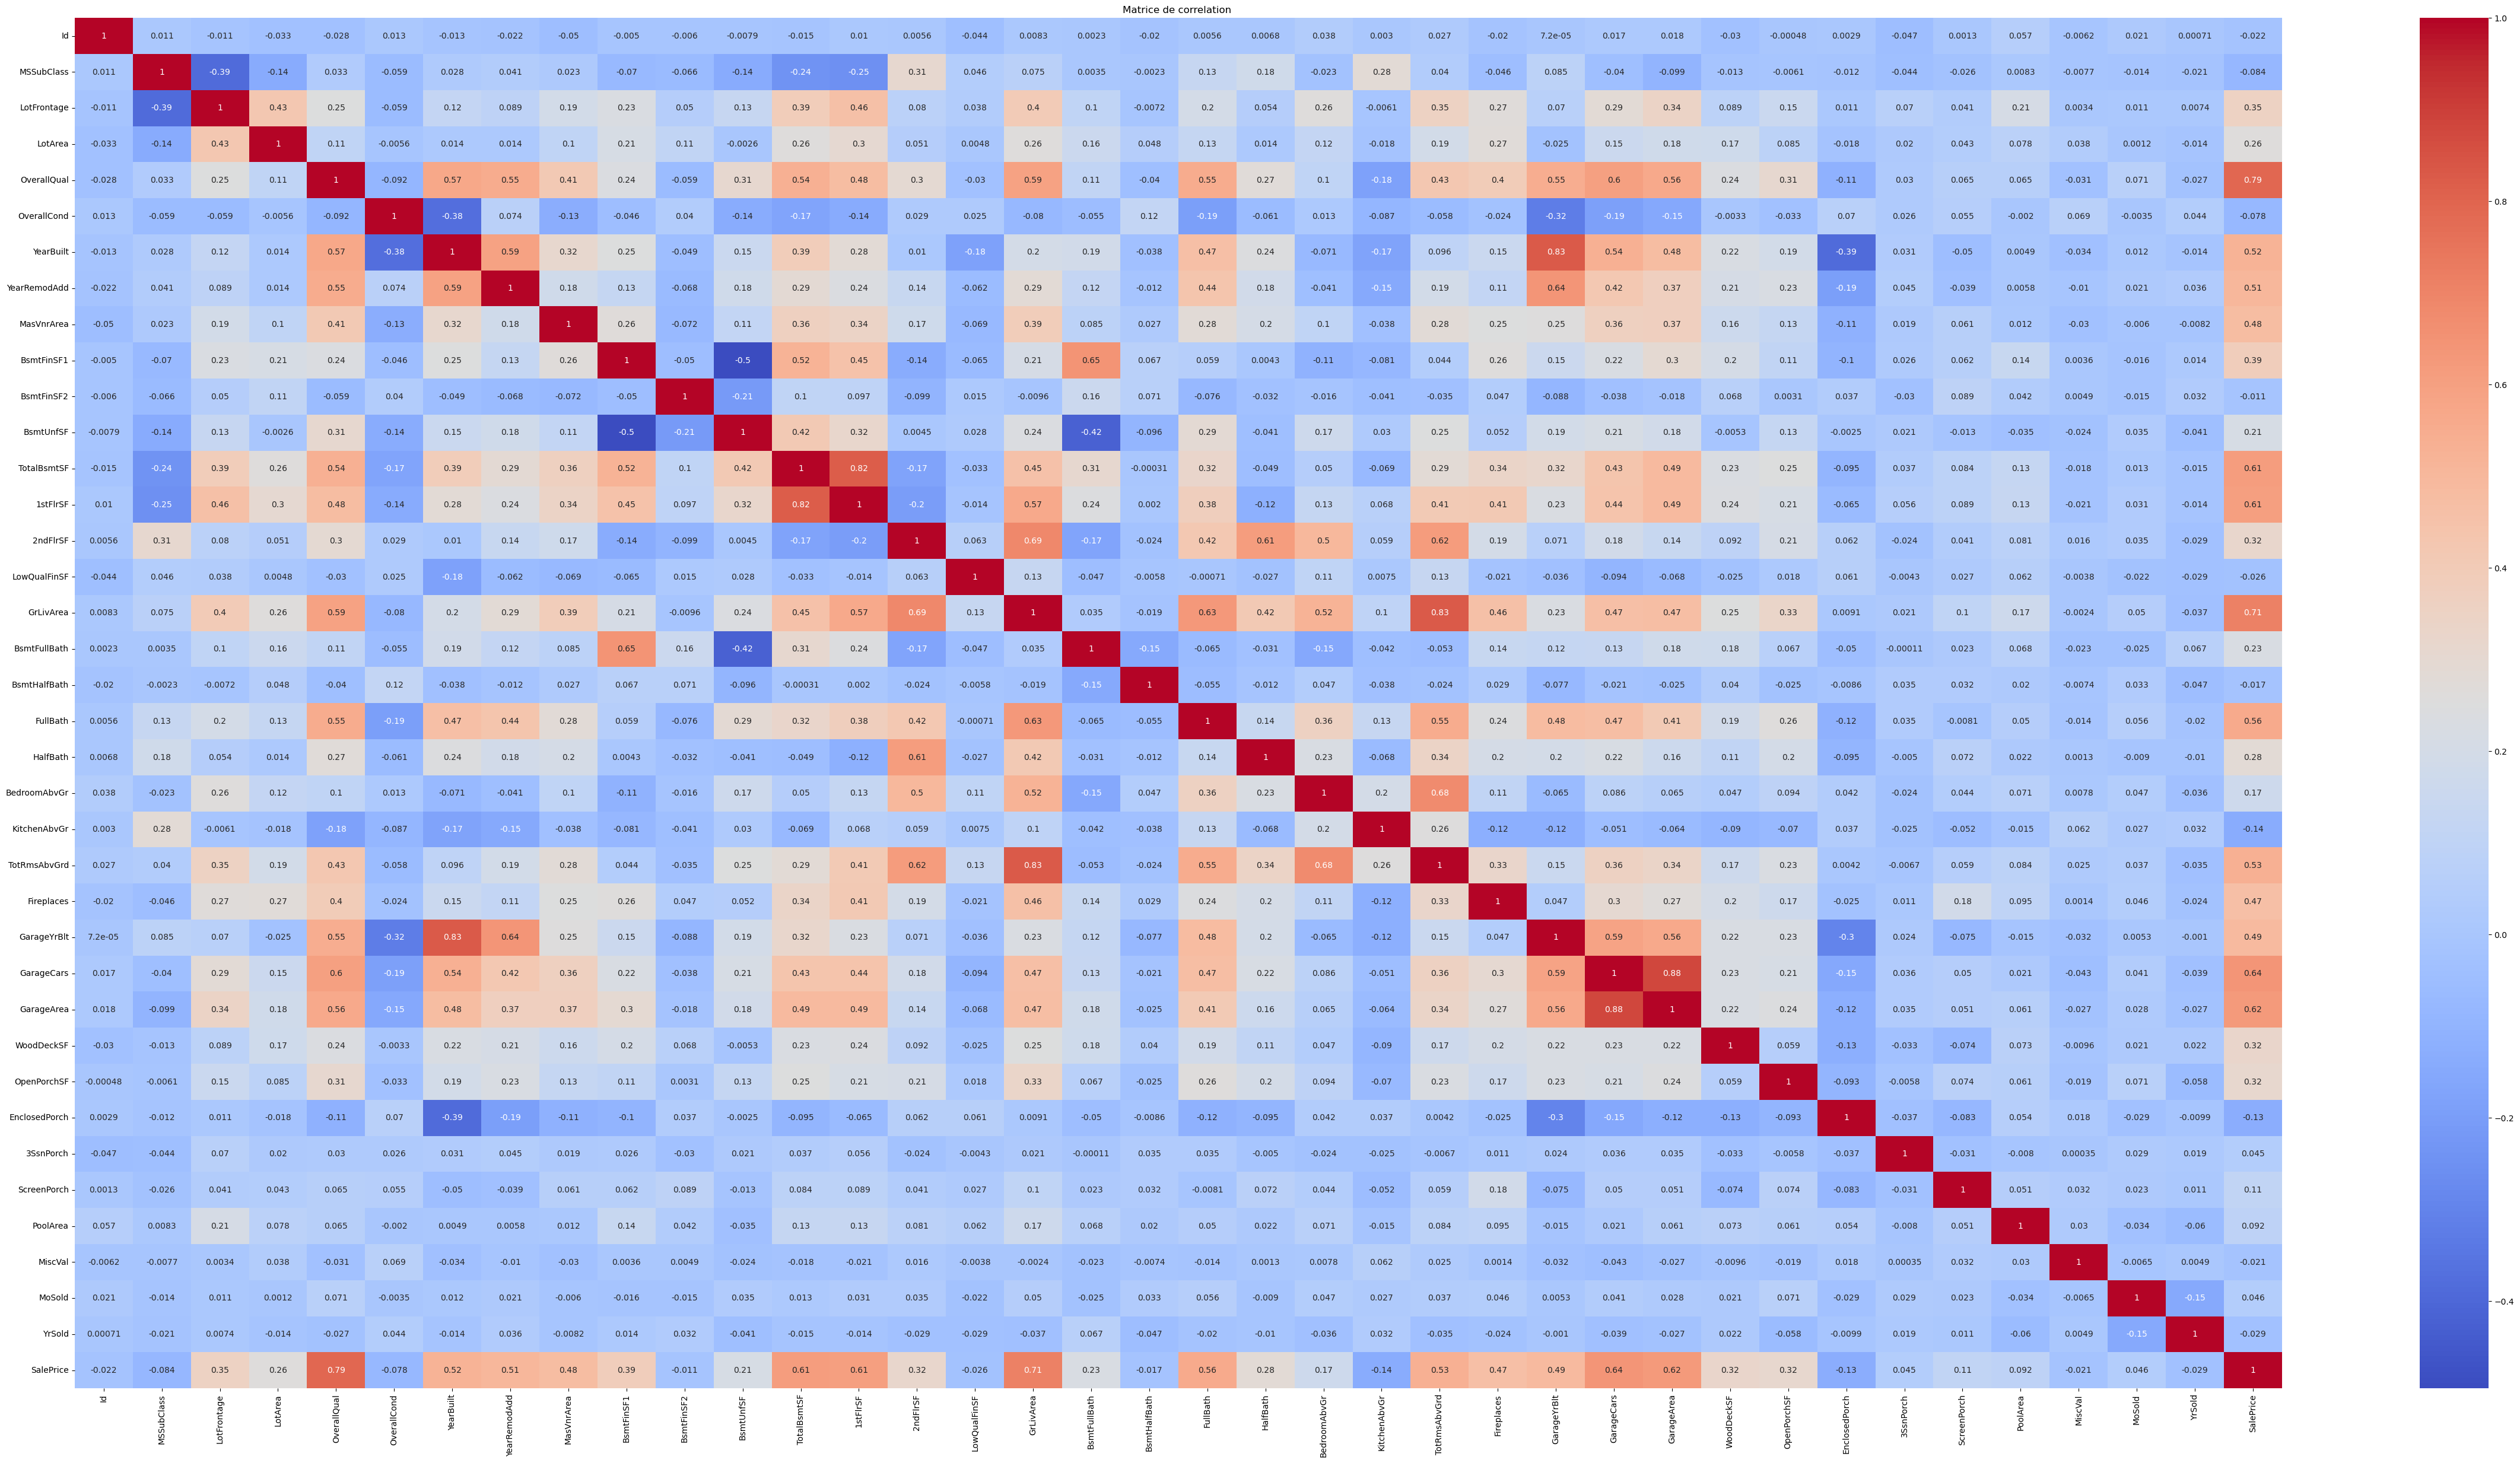

In [18]:
## matrice de correlation 
numeric_cols=data_train.select_dtypes(include=["int64",'float64']).columns[:len(data_train)]
cor_matrix=data_train[numeric_cols].corr()
plt.figure(figsize=(60,30))
ax=sns.heatmap(cor_matrix,annot=True,cmap="coolwarm")
ax.set_title("Matrice de correlation ")
plt.show()

On constate que le prix de ventes des maisons est fortement corrélée avec la qualité globales des materiaux et des finitions et avec la surfaces habitables hors sol ,respectivement (79%, 71% ) et moyennement correlé avec d'autres variables . notons aussi que certaines variables explicativess sont correlé entre eux . 

- II-4-) visualisation des valeurs manquantes 

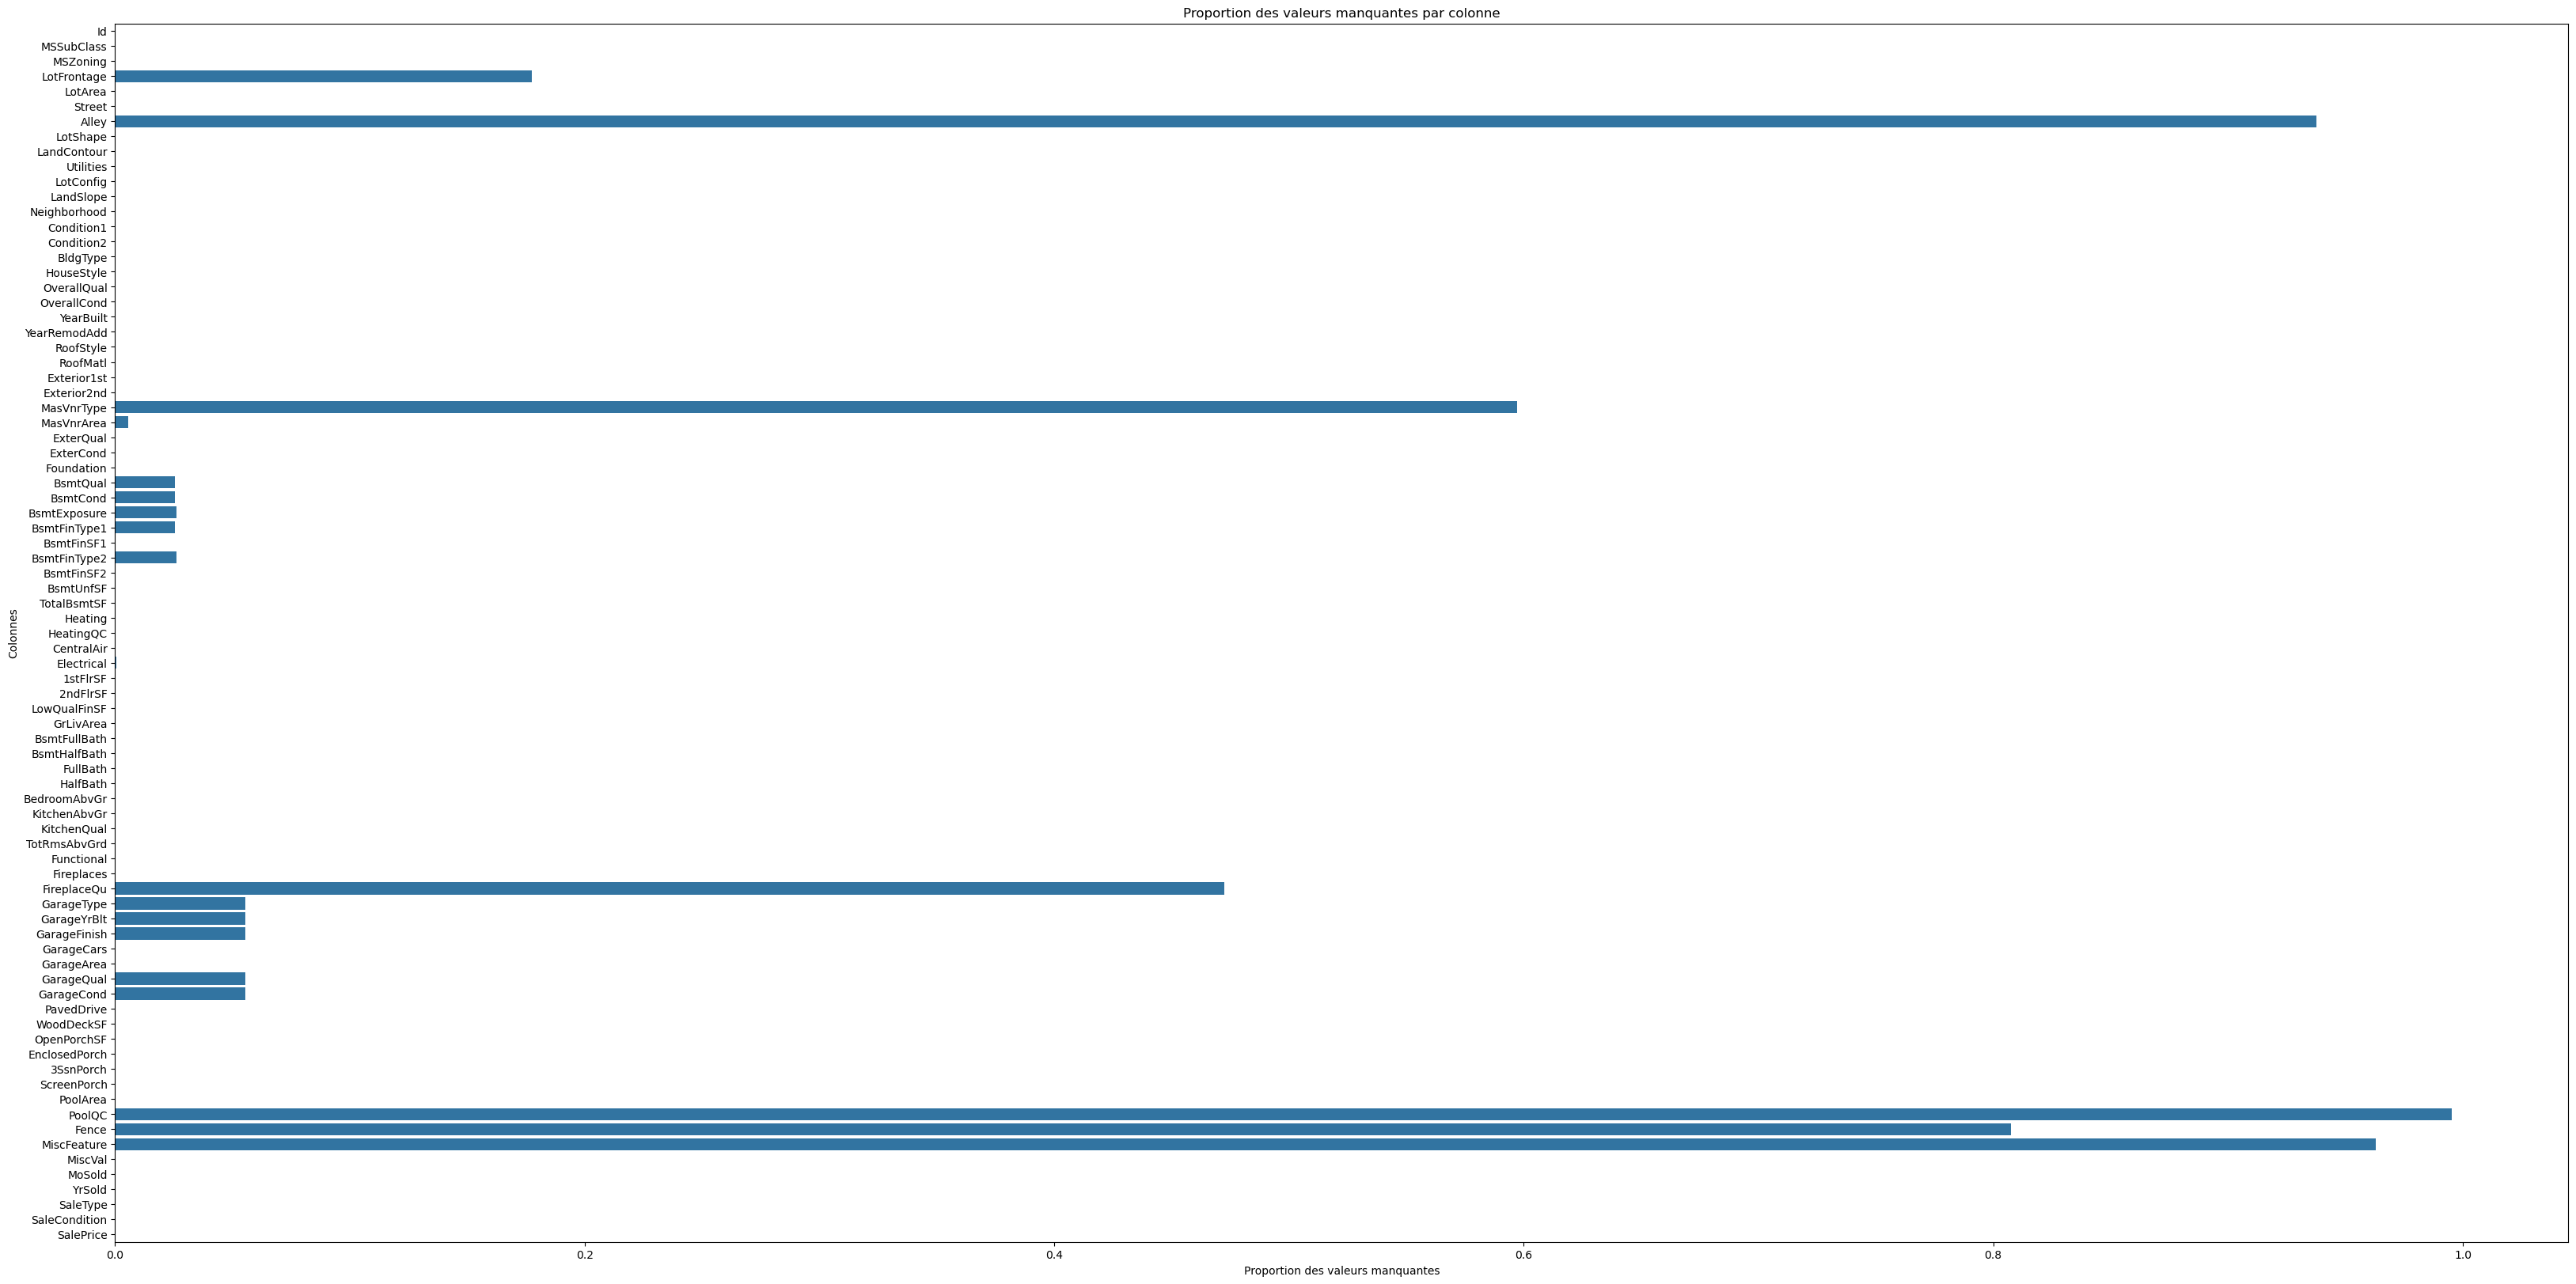

In [19]:
## visualisation des valeurs manquantes 
plt.figure(figsize=(40,20))
sns.barplot(x=data_train.isnull().sum()/data_train.shape[0],y=data_train.columns)
plt.title("Proportion des valeurs manquantes par colonne")
plt.xlabel("Proportion des valeurs manquantes")
plt.ylabel("Colonnes")
plt.show()


In [20]:
#print(f"{(data_train.isnull().sum()/data_train.shape[0])*100 }")
colonnes=[]
pourcentage=[]
for col in data_train.columns[data_train.isnull().any()]:
    colonnes.append(col)
    pourcentage.append((data_train[col].isnull().sum()/data_train.shape[0])*100)
data=[colonnes,pourcentage]
tableau=pd.DataFrame(data,index=["Colonnes","Pourcentage des valeurs manquantes"]).T
print(tableau)


        Colonnes Pourcentage des valeurs manquantes
0    LotFrontage                          17.739726
1          Alley                          93.767123
2     MasVnrType                          59.726027
3     MasVnrArea                           0.547945
4       BsmtQual                           2.534247
5       BsmtCond                           2.534247
6   BsmtExposure                            2.60274
7   BsmtFinType1                           2.534247
8   BsmtFinType2                            2.60274
9     Electrical                           0.068493
10   FireplaceQu                          47.260274
11    GarageType                           5.547945
12   GarageYrBlt                           5.547945
13  GarageFinish                           5.547945
14    GarageQual                           5.547945
15    GarageCond                           5.547945
16        PoolQC                          99.520548
17         Fence                          80.753425
18   MiscFea

In [21]:
inf_val=[]
for i in tableau.index:
    if tableau["Pourcentage des valeurs manquantes"][i]<5:
        inf_val.append(tableau["Colonnes"][i])
print("les colonnes ayant moins de 5% de valeurs manquantes sont :")
print(inf_val)
sup_val=[]
for i in tableau.index: 
    if tableau["Pourcentage des valeurs manquantes"][i]>5 and tableau["Pourcentage des valeurs manquantes"][i]<50:
        sup_val.append(tableau["Colonnes"][i])  
print("="*150)
print("les colonnes ayant entre 5% et 50% de valeurs manquantes sont :")
print(sup_val)
ext_val=[]
for i in tableau.index:
    if tableau["Pourcentage des valeurs manquantes"][i]>50:
        ext_val.append(tableau["Colonnes"][i])
print("="*150)
print("les colonnes ayant plus de 50% de valeurs manquantes sont :")
print(ext_val)

les colonnes ayant moins de 5% de valeurs manquantes sont :
['MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical']
les colonnes ayant entre 5% et 50% de valeurs manquantes sont :
['LotFrontage', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
les colonnes ayant plus de 50% de valeurs manquantes sont :
['Alley', 'MasVnrType', 'PoolQC', 'Fence', 'MiscFeature']


- II-5-) visualisation et detection  de valeurs extremes




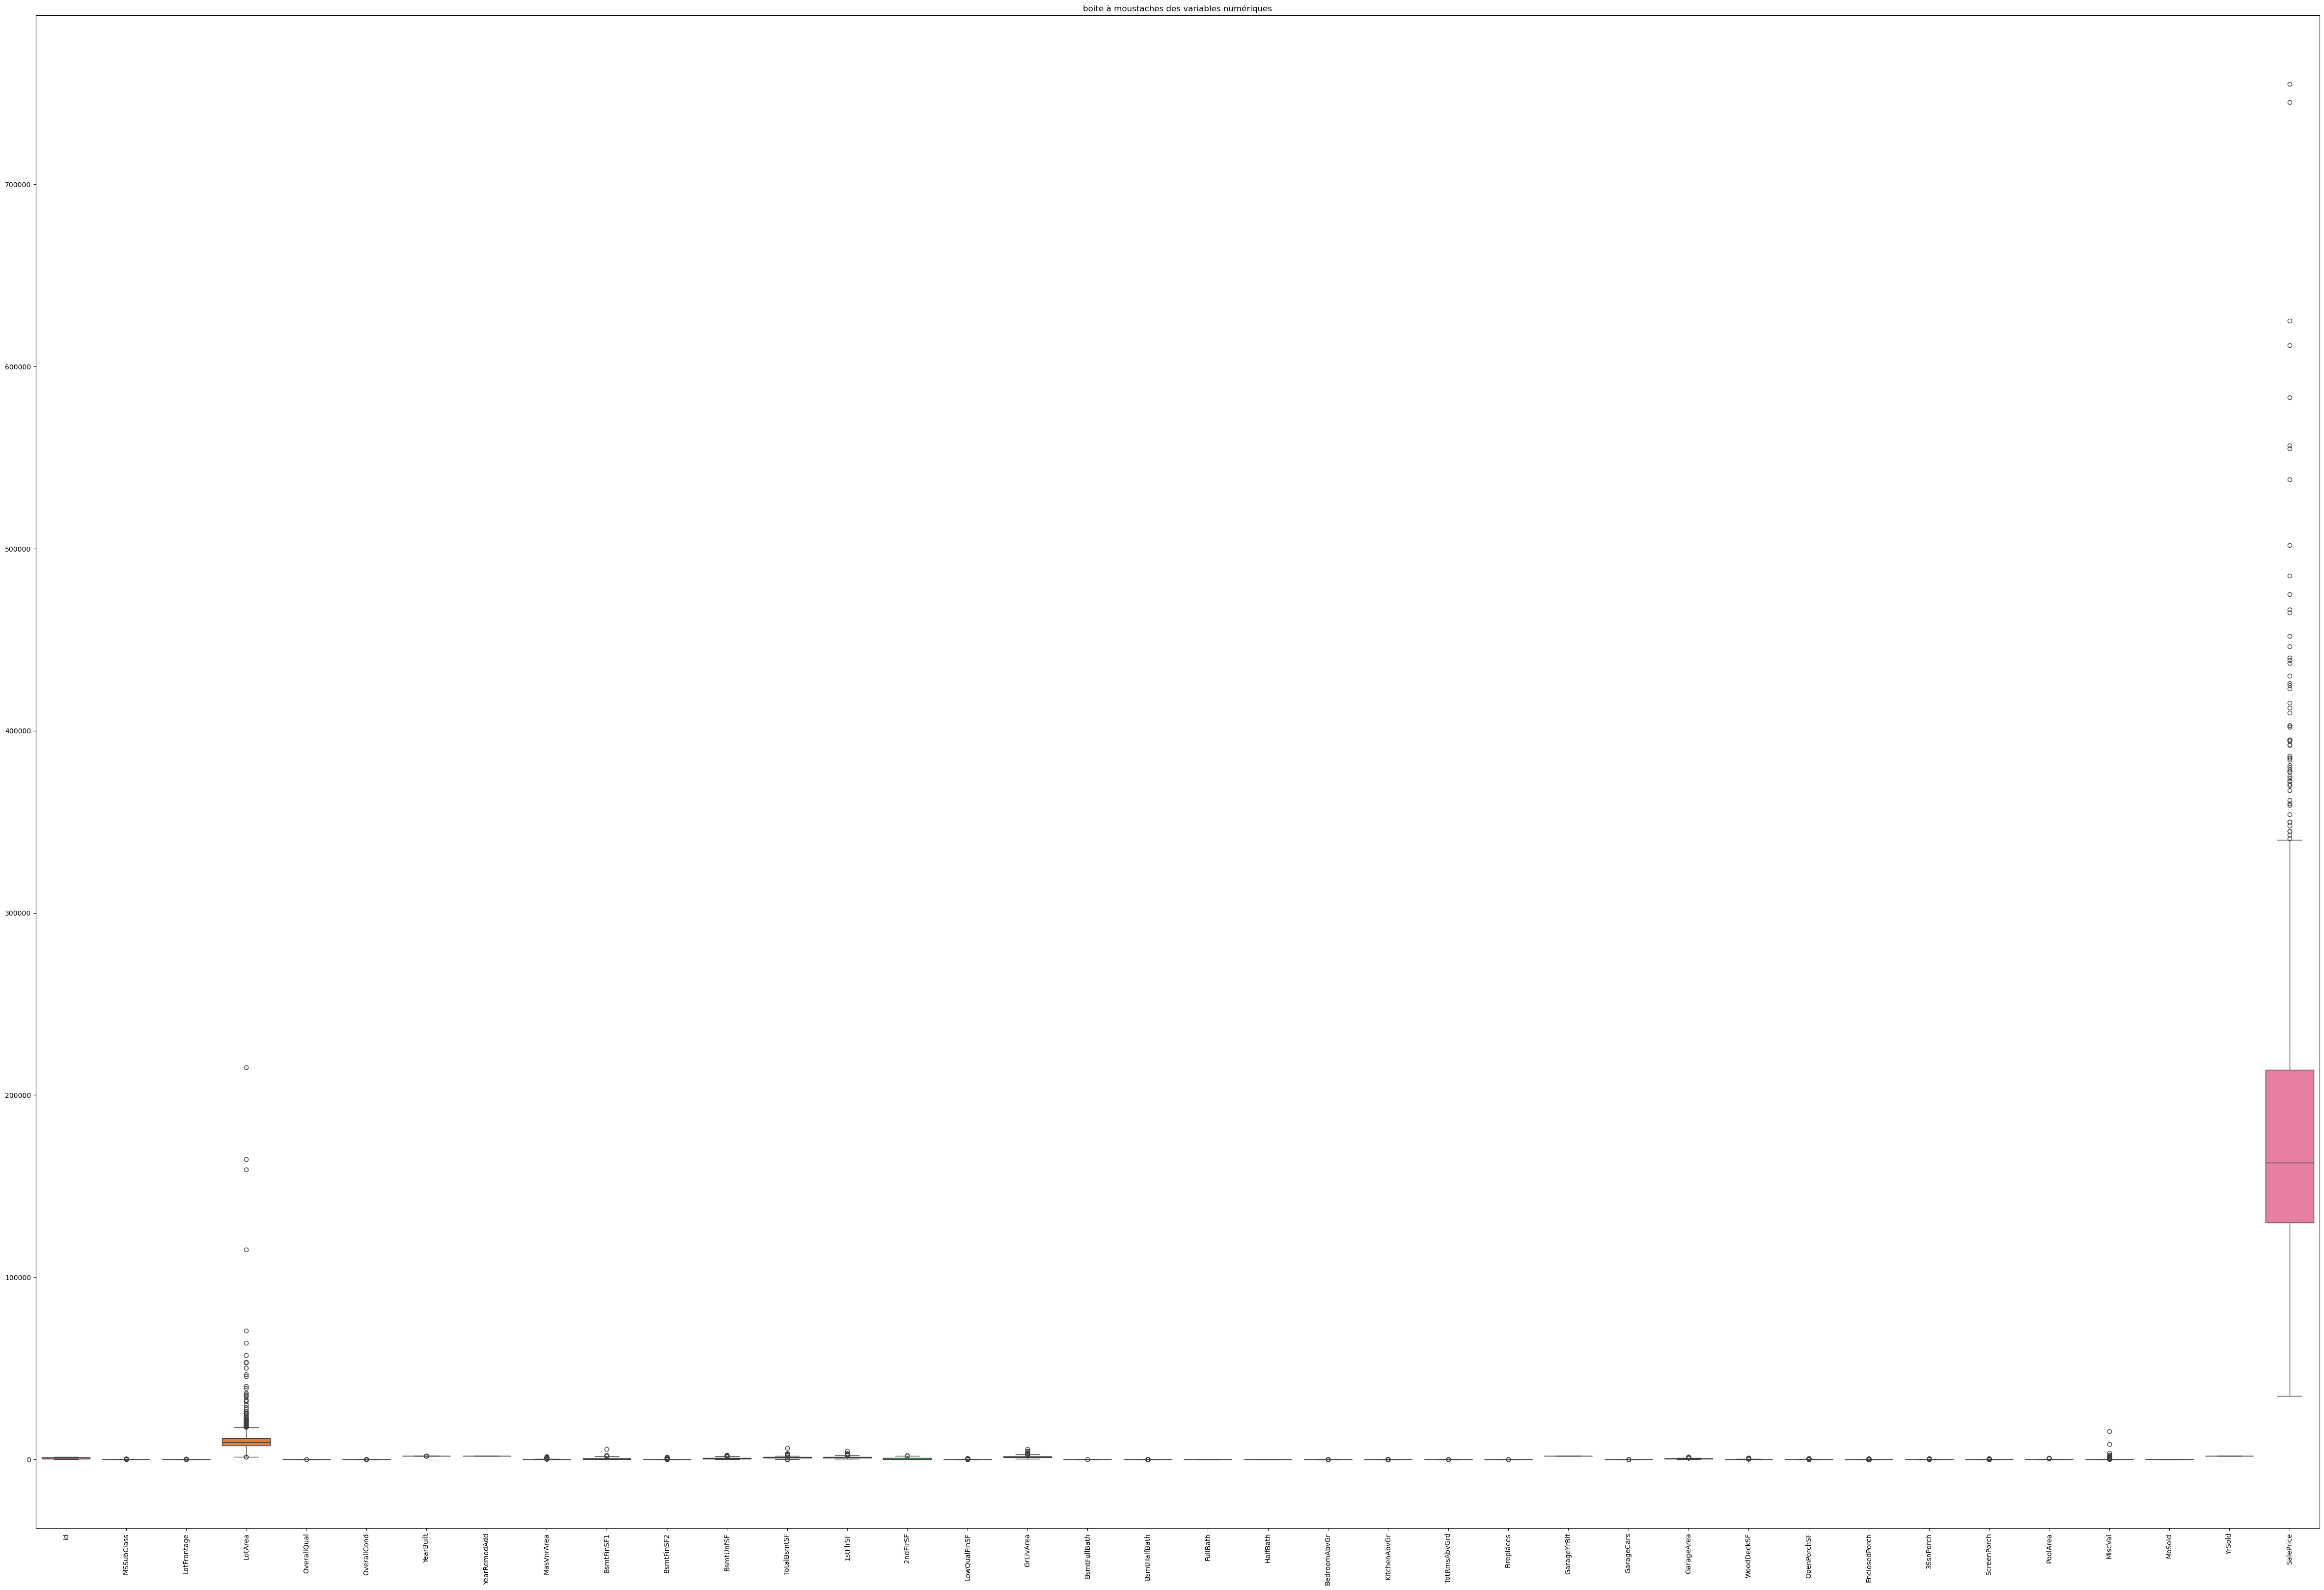

In [22]:
## Visualisation de la distribution des variables
plt.figure(figsize=(60, 40))
sns.boxplot(data_train[numeric_cols])
plt.xticks(rotation=90)
plt.title("boite à moustaches des variables numériques")
plt.show()

On constate qu'a l'exception de 7 variables ( sur 81 ) ,toutes les variables explicatives ont des valeurs extremes . Mais dans le cas de notre études ,ces valeurs extremes sont informatives et elle nous seront utilent dans notre analyse même si elle ne sont representativent. 

- II-6-) Traitement des valeurs manquantes et des valeurs extremes 

- pour cette premiere partie du traitement des données, nous supprimons les variables explicatives qui ont moins de 5% de valeurs manquantes . 
- Et aussi nous avons imputer la variable "Lotfrontage" par la mediane car supprimer 17% du jeu de données reduira considerablement le jeu de données et reduira la perfomance et la precision de notre analyse et de nos modeles . 

In [23]:
## traitement des valeurs manquantes
data_clean=data_train.dropna(subset=["MasVnrArea","BsmtQual","BsmtCond","BsmtExposure", 'BsmtFinType1', 'BsmtFinType2','Electrical'],axis=0)
data_clean.loc[:, "LotFrontage"] = data_clean["LotFrontage"].fillna(data_clean["LotFrontage"].median())


- ici nous remplacons tous les Na par 0 car apres inspections de la description des données on constate que toutes les valeurs manquantes sont dû au fait que la maison n'a pas de garage et donc l'année de construction du garage pour cette maison sera evidemment inexistente . 

In [24]:
data_clean.loc[:, "GarageYrBlt"] = data_clean["GarageYrBlt"].fillna(0)

- pareil ,pour ces variables ci-dessous ,la description des données montrent que les "Na"(valeurs manquantes ) sont en realité une modalité des ces variables la ,et donc le traitement des valeurs manquantes consistera a remplacer toutes les valeurs manquantes par une nouvelle modalité "None". 

In [25]:
data_clean[['Alley',"FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence",'MasVnrType',"MiscFeature"]].fillna("None")

,Alley,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MasVnrType,MiscFeature
0,None,None,Attchd,RFn,TA,TA,None,None,BrkFace,None
1,None,TA,Attchd,RFn,TA,TA,None,None,None,None
2,None,TA,Attchd,RFn,TA,TA,None,None,BrkFace,None
3,None,Gd,Detchd,Unf,TA,TA,None,None,None,None
4,None,TA,Attchd,RFn,TA,TA,None,None,BrkFace,None
...,...,...,...,...,...,...,...,...,...,...
1455,None,TA,Attchd,RFn,TA,TA,None,None,None,None
1456,None,TA,Attchd,Unf,TA,TA,None,MnPrv,Stone,None
1457,None,Gd,Attchd,RFn,TA,TA,None,GdPrv,None,Shed
1458,None,None,Attchd,Unf,TA,TA,None,None,None,None


- ici nous procédons a l'encodage des valeurs mannquantes . 

In [26]:
## encodage des variables catégorielles
cat_cols = data_clean.select_dtypes(include=["object"]).columns
data_clean = pd.get_dummies(data_clean, columns=cat_cols, drop_first=True).astype(int)

In [27]:
data_clean_mod=data_clean.copy()
data_clean_ana=data_clean.copy()

- Pour la construction de nos modeles ,principalement a cause du modele de regression lineaire qui est sensible a l'asymetrie des données , nous effectuons une transformation logarithmique pour reduire l'asymetrie des données et une standarisation des données . 

In [28]:
## Traitement des valeurs extremes (seulement pour la creation des modeles )
for col in numeric_cols:
    data_clean_mod.loc[:,f"{col}_log"] = np.log1p(data_clean_mod[col].clip(lower=0))
data_clean_mod.head(5)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF_log,OpenPorchSF_log,EnclosedPorch_log,3SsnPorch_log,ScreenPorch_log,PoolArea_log,MiscVal_log,MoSold_log,YrSold_log,SalePrice_log
0,1,60,65,8450,7,5,2003,2003,196,706,...,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,1.098612,7.605392,12.247699
1,2,20,80,9600,6,8,1976,1976,0,978,...,5.700444,0.000000,0.000000,0.0,0.0,0.0,0.0,1.791759,7.604894,12.109016
2,3,60,68,11250,7,5,2001,2002,162,486,...,0.000000,3.761200,0.000000,0.0,0.0,0.0,0.0,2.302585,7.605392,12.317171
3,4,70,60,9550,7,5,1915,1970,0,216,...,0.000000,3.583519,5.609472,0.0,0.0,0.0,0.0,1.098612,7.604396,11.849405
4,5,60,84,14260,8,5,2000,2000,350,655,...,5.262690,4.442651,0.000000,0.0,0.0,0.0,0.0,2.564949,7.605392,12.429220


In [29]:
## standarisation des valeurs 
num=data_clean_mod.select_dtypes(include=["int64","float64"]).columns
scaler = StandardScaler()
data_clean_std = data_clean_mod.copy()
data_clean_std[num] = scaler.fit_transform(data_clean_mod[num])

- Apres inspection de le matrice de correlation on constate que les variables GarageCars et GarageArea ont une très forte correlation (88%) et apportent a peu près la même information (qui est des savoir quel est la capacités du garage ),et donc nous allons supprimer une des variables . 

In [30]:
data_clean_ana.drop("GarageCars",axis=1,inplace=True)
data_clean_std.drop("GarageCars",axis=1,inplace=True)

- III-) Construction des modéles . 

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Ajouter une constante (si nécessaire pour le modèle)
df = add_constant(data_clean_std.select_dtypes(include=["int64","float64"]))

# Calculer le VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["Variable"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Afficher les résultats
print(vif_data)

             Variable        VIF
0               const   1.000000
1              Id_log   1.026150
2      MSSubClass_log   2.356149
3     LotFrontage_log   2.033955
4         LotArea_log   2.403018
5     OverallQual_log   3.518459
6     OverallCond_log   1.685456
7       YearBuilt_log   4.793999
8    YearRemodAdd_log   2.322733
9      MasVnrArea_log   1.433135
10     BsmtFinSF1_log   2.082074
11     BsmtFinSF2_log   1.259127
12      BsmtUnfSF_log   1.840956
13    TotalBsmtSF_log   4.751384
14       1stFlrSF_log  20.100054
15       2ndFlrSF_log  19.539619
16   LowQualFinSF_log   1.397144
17      GrLivArea_log  32.357107
18   BsmtFullBath_log   2.024924
19   BsmtHalfBath_log   1.164224
20       FullBath_log   3.047421
21       HalfBath_log   2.351980
22   BedroomAbvGr_log   2.326795
23   KitchenAbvGr_log   1.483898
24   TotRmsAbvGrd_log   4.671319
25     Fireplaces_log   1.640525
26    GarageYrBlt_log  38.150171
27     GarageCars_log   9.602972
28     GarageArea_log  63.214288
29     Woo

on constate apres avoir fait le facteur d'influence de la variance de chaques variables quantitatives que 7 variables quantitatives sont corrélés ,ce qui nous suggere d'utiliser ,pour la regression lineaire car elle est sensibles a la multicolinearité , des modeles qui penalisent les correlations . 

III-1) Modele de regression lineaire . 
- Pour la construction de nos modèles lineaires nous allons construire trois modèles et en selectionné un qui sera comparé ulterieurement avec les autres modeles qui seront construits . Ces trois modeles sont : Ridge ,Lasso et l'Elastic Net ;, qui sont des modèles lineaires adéquat a notre jeu de donnée ;car elle presente une colinearité entre plusieurs variables . 

In [32]:
## Séparation des features et de la target
y=data_clean_std["SalePrice_log"]
x=data_clean_std.drop(["SalePrice","SalePrice_log"],axis=1)


In [39]:
y_train, y_test, x_train, x_test = train_test_split(y, x, test_size=0.2, random_state=42)


In [44]:
## entrainement et evaluation des modeles
from sklearn.model_selection import KFold, cross_val_score

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=1.0)
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error')
    print(f"{name} RMSE moyen (CV 5 folds): {-scores.mean():.4f}")

Ridge RMSE moyen (CV 5 folds): 0.3341
Lasso RMSE moyen (CV 5 folds): 0.4814
ElasticNet RMSE moyen (CV 5 folds): 0.4800


on constate que le modele Ridge a le RMSE moyen le plus bas ,d'ou il sera notre modele retenue pour la premiere etapes . 

- Maintenant passons a la construction de nos modeles non lineaires .

In [58]:
## entrainement des autres modeles  
def entrainement_modeles(x_train, y_train):
    modele = {}
    
    try:
        ## Modele Random Forest
        print("Entraînement du Random Forest...")
        mod_ran_for = RandomForestRegressor(random_state=29)
        param = {"n_estimators": [100, 150, 200, 500], "max_depth": [2, 4, 6, 8, 10]}
        grid = GridSearchCV(estimator=mod_ran_for, param_grid=param, cv=5)
        grid.fit(x_train, y_train)
        a = grid.best_params_
        print(f"Meilleurs paramètres RandomForest: {a}")
        modele["RandomForest"] = grid.best_estimator_
        print("✓ Random Forest terminé.")

        ## Modele LightGBM
        print("Entraînement de LightGBM...")
        mod_light = lgb.LGBMRegressor(verbosity=0, random_state=29)
        param = {"n_estimators": [100, 150, 200, 500], "num_leaves": [20, 31, 50], "learning_rate": [0.01, 0.05, 0.1]}
        grid_light = GridSearchCV(estimator=mod_light, param_grid=param, cv=5)
        grid_light.fit(x_train, y_train)
        modele["LightGBM"] = grid_light.best_estimator_
        print("✓ LightGBM terminé.")

        ## Modele XGBoost
        print("Entraînement de XGBoost...")
        mod_xg = xgb.XGBRegressor(verbosity=0, random_state=29)
        param = {"n_estimators": [100, 150, 200, 500], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 4, 5]}
        grid_xg = GridSearchCV(estimator=mod_xg, param_grid=param, cv=5)
        grid_xg.fit(x_train, y_train)
        modele["XGBoost"] = grid_xg.best_estimator_
        print("✓ XGBoost terminé.")

        print("Tous les modèles sont bien entraînés !")
        
    except Exception as e:
        # Cette partie attrape n'importe quelle erreur et affiche un message utile
        print(f"\n❌ Une erreur s'est produite lors de l'entraînement d'un modèle : {e}")
        # Vous pouvez choisir de lever l'exception à nouveau ou de retourner le dictionnaire partiel
        # raise e

    return modele

In [57]:
from sklearn.model_selection import cross_val_score, KFold

# Entraînement des modèles (classification)
modeles = entrainement_modeles(x_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in modeles.items():
    scores = cross_val_score(model, x, y, cv=kf, scoring='accuracy')
    print(f"{name} Accuracy moyen (CV 5 folds): {scores.mean():.4f}")

Entraînement du Random Forest...
Meilleurs paramètres RandomForest: {'max_depth': 10, 'n_estimators': 500}
✓ Random Forest terminé.
Entraînement de LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

RandomForest Accuracy moyen (CV 5 folds): nan
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LightGBM Accuracy moyen (CV 5 folds): nan


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py", line 231, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
                

A faire pour demain : 
- documenter mon travail 
- passer aux analyses et a la construction des modeles .  